In [1]:
import os
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2

from tensorflow.keras.layers import (
    Dropout,
    Flatten,
    Dense,
    Input,
)
from tensorflow.keras.preprocessing.image import (
    load_img,
    img_to_array,
)
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np

c:\Users\ADMIN\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h1>Model Baseline

In [2]:
annotations_data_path = "./data/annotations/"
images_data_path = "./data/images/"

In [3]:
target_size = (300, 300)

In [4]:
df = pd.DataFrame(
    columns=["img_path", "w", "h", "xmin", "ymin", "xmax", "ymax"]
)

<h3> Data Preparasion

In [5]:
for f in os.listdir(annotations_data_path):
    xml_tree = ET.parse(annotations_data_path + f)
    bbox_xml = xml_tree.getroot().find("object").find("bndbox")
    size_xml = xml_tree.getroot().find("size")
    w = int(size_xml.find("width").text)
    h = int(size_xml.find("height").text)

    xmin = int(bbox_xml.find("xmin").text)
    ymin = int(bbox_xml.find("ymin").text)
    xmax = int(bbox_xml.find("xmax").text)
    ymax = int(bbox_xml.find("ymax").text)

    img_path = images_data_path + xml_tree.getroot().find("filename").text
    new_row = pd.DataFrame(
        {
            "img_path": img_path,
            "w": w,
            "h": h,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
        },
        index=[0],
    )

    df = pd.concat([df, new_row], ignore_index=True)
df

,img_path,w,h,xmin,ymin,xmax,ymax
0,./data/images/Cars0.png,500,268,226,125,419,173
1,./data/images/Cars1.png,400,248,134,128,262,160
2,./data/images/Cars10.png,400,225,140,5,303,148
3,./data/images/Cars100.png,400,267,175,114,214,131
4,./data/images/Cars101.png,400,300,167,202,240,220
...,...,...,...,...,...,...,...
428,./data/images/Cars95.png,600,400,278,182,407,263
429,./data/images/Cars96.png,400,248,133,126,261,160
430,./data/images/Cars97.png,400,300,98,102,297,191
431,./data/images/Cars98.png,370,400,85,196,247,259


<h5> Data normalization

In [6]:
images = []
bboxes = []

In [7]:
for idx, row in df.iterrows():
    img = load_img(row["img_path"])
    resized_img = img.resize(target_size)
    resized_array = img_to_array(resized_img)
    w = row["w"]
    h = row["h"]
    x_scale = target_size[0] / w
    y_scale = target_size[1] / h

    xmin = int(row["xmin"] * x_scale) / target_size[0]
    ymin = int(row["ymin"] * y_scale) / target_size[1]
    xmax = int(row["xmax"] * x_scale) / target_size[0]
    ymax = int(row["ymax"] * y_scale) / target_size[1]

    images.append(resized_array)
    bboxes.append([xmin, ymin, xmax, ymax])

In [8]:
images = np.array(images, dtype='float32') / 255.0
bboxes = np.array(bboxes)

In [9]:
images_train, images_val, bboxes_train, bboxes_val = train_test_split(
    images, bboxes, test_size=0.2, random_state=12
)

# VGG16

<h5> Modeling

<h5> Using Transfer Learning

In [10]:
base_learning_rate = 0.000015

opt = Adam(base_learning_rate)

In [11]:
input_images = Input(shape=(300, 300, 3), name="input_images")

base_model = VGG16(
    weights="imagenet", include_top=False, input_tensor=input_images
)
base_model.trainable = False
base_out = base_model.output
flatten_output = Flatten()(base_out)
bbox_layers = Dense(512, activation="relu")(flatten_output)
bbox_layers = Dense(256, activation="relu")(bbox_layers)
bbox_layers = Dense(128, activation="relu")(bbox_layers)
bbox_layers = Dropout(0.25)(bbox_layers)
bounding_box = Dense(4, activation="sigmoid", name="bounding_box")(bbox_layers)


model_ssd = Model(
    inputs=base_model.input,
    outputs=bounding_box,
)
model_ssd.compile(
    optimizer=opt,
    loss="mse",
    metrics=["accuracy"],
)
model_ssd.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_images (InputLayer)   [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [12]:
with tf.device("/CPU:0"):
    model_ssd.fit(
        images_train,
        bboxes_train,
        validation_data=(
            images_val,
            bboxes_val,
        ),
        epochs=20,
        batch_size=32,
        verbose=1,
    )

Epoch 1/20
11/11 [==============================] - 39s 3s/step - loss: 0.0403 - accuracy: 0.4769 - val_loss: 0.0282 - val_accuracy: 0.4943
Epoch 2/20
11/11 [==============================] - 38s 4s/step - loss: 0.0233 - accuracy: 0.6445 - val_loss: 0.0217 - val_accuracy: 0.6207
Epoch 3/20
11/11 [==============================] - 38s 3s/step - loss: 0.0167 - accuracy: 0.6850 - val_loss: 0.0189 - val_accuracy: 0.6092
Epoch 4/20
11/11 [==============================] - 38s 3s/step - loss: 0.0131 - accuracy: 0.7457 - val_loss: 0.0174 - val_accuracy: 0.6322
Epoch 5/20
11/11 [==============================] - 38s 3s/step - loss: 0.0101 - accuracy: 0.7514 - val_loss: 0.0173 - val_accuracy: 0.6092
Epoch 6/20
11/11 [==============================] - 38s 4s/step - loss: 0.0084 - accuracy: 0.8179 - val_loss: 0.0173 - val_accuracy: 0.6437
Epoch 7/20
11/11 [==============================] - 38s 3s/step - loss: 0.0072 - accuracy: 0.8006 - val_loss: 0.0165 - val_accuracy: 0.6667
Epoch 8/20
11/11 [==

In [13]:
model_ssd.save("./model/detection.h5")

c:\Users\ADMIN\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h5> Prediction

In [14]:
loaded_model = load_model("./model/detection.h5")

In [15]:
def plate_detection(path, model, size):
    ima = load_img(path)
    resized_image = ima.resize(size)

    resized_array = img_to_array(resized_image) / 255.0
    test_arr = resized_array.reshape(1, size[0], size[1], 3)

    prediction = model.predict(test_arr)
    predicted_bbox = prediction * 300
    predicted_bbox = np.array(predicted_bbox[0], dtype=np.uint8)
    xmin, ymin, xmax, ymax = predicted_bbox
    cv2.rectangle(resized_array, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    return resized_array, predicted_bbox

In [16]:
test_img_path = "./data/test_card.png"
image, prediction = plate_detection(test_img_path, model_ssd, target_size)

1/1 [==============================] - 0s 253ms/step


In [17]:
prediction

array([125, 154, 188, 202], dtype=uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


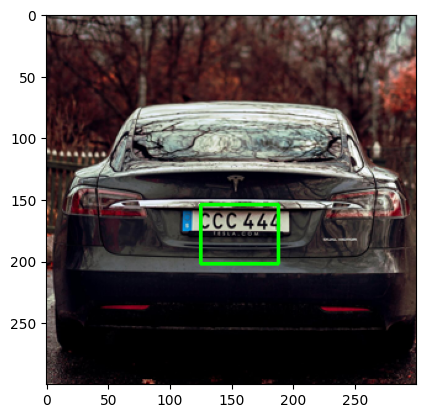

In [18]:
plt.imshow(image)
plt.show()

<h1> YOLOv8

<h3> Data Preparasion

In [4]:
from ultralytics import YOLO
from random import shuffle
import shutil

In [20]:
yolo_model = YOLO('yolov8n.pt')

Convert Pascal VOC to YOLO Style

In [21]:
os.makedirs("./data/labels", exist_ok=True)

In [22]:
def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    return [
        ((x2 + x1) / (2 * image_w)),
        ((y2 + y1) / (2 * image_h)),
        (x2 - x1) / image_w,
        (y2 - y1) / image_h,
    ]

In [23]:
for file in os.listdir(annotations_data_path):
    xml_tree = ET.parse(annotations_data_path + file)
    bbox_xml = xml_tree.getroot().find("object").find("bndbox")
    size_xml = xml_tree.getroot().find("size")
    w = int(size_xml.find("width").text)
    h = int(size_xml.find("height").text)

    xmin = int(bbox_xml.find("xmin").text)
    ymin = int(bbox_xml.find("ymin").text)
    xmax = int(bbox_xml.find("xmax").text)
    ymax = int(bbox_xml.find("ymax").text)

    yolo_box = pascal_voc_to_yolo(xmin, ymin, xmax, ymax, w, h)
    lf = open(f"./data/labels/{file.split('.')[0]}.txt", "x")
    lf = open(f"./data/labels/{file.split('.')[0]}.txt", "w")
    lf.write(
        f"0 {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]}"
    )

In [24]:
labels_path = "./data/labels/"

In [25]:
train_dir = "./data/train/"
val_dir = "./data/val/"
os.makedirs(train_dir + "/images", exist_ok=True)
os.makedirs(train_dir + "/labels", exist_ok=True)
os.makedirs(val_dir + "/images", exist_ok=True)
os.makedirs(val_dir + "/labels", exist_ok=True)

In [26]:
files = os.listdir(images_data_path)
shuffle(files)

In [27]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]


def copy_files(images_path, labels_path, destination_path, files):
    for file_name in files:
        file_name = file_name.split(".")[0]

        src = images_path + f"{file_name}.png"
        dst = destination_path + "/images"
        shutil.copy(src, dst)

        src = labels_path + f"{file_name}.txt"
        dst = destination_path + "/labels"
        shutil.copy(src, dst)

In [28]:
train_ratio = 0.8
train_files, val_files = split(files, train_ratio)

copy_files(images_data_path, labels_path, train_dir, train_files)
copy_files(images_data_path, labels_path, val_dir, val_files)

In [29]:
with open(f"./data/training_data.yaml", "w") as f:
    f.write("train: ./train/images\n")
    f.write("val: ./val/images\n")
    f.write("nc: 1\n")
    f.write("names: {0: 'plate'}")

In [30]:
results = yolo_model.train(
    data="./data/training_data.yaml", epochs=20, imgsz=320
)
results = yolo_model.val()

New https://pypi.org/project/ultralytics/8.1.5 available 😃 Update with 'pip install -U ultralytics'


Ultralytics YOLOv8.0.233 🚀 Python-3.9.13 torch-2.1.0+cpu CPU (AMD Ryzen 7 6800H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./data/training_data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

train: Scanning C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Object Detection\car-plate-detection\data\train\labels... 346 images, 1 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:00<00:00, 656.83it/s]

train: New cache created: C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Object Detection\car-plate-detection\data\train\labels.cache



val: Scanning C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Object Detection\car-plate-detection\data\val\labels... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 558.03it/s]

val: New cache created: C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Object Detection\car-plate-detection\data\val\labels.cache


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.681      2.791      1.288         20        320: 100%|██████████| 22/22 [00:19<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         87    0.00357       0.92      0.603      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.547      1.559      1.138         23        320: 100%|██████████| 22/22 [00:18<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         87      0.854     0.0674      0.476      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.572      1.472      1.184         17        320: 100%|██████████| 22/22 [00:18<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         87         87      0.962      0.295      0.474      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G       1.56      1.391      1.175         21        320: 100%|██████████| 22/22 [00:18<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         87      0.387       0.23      0.209     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.575      1.331       1.22         11        320: 100%|██████████| 22/22 [00:18<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         87      0.501      0.345      0.374       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.461      1.268      1.172         20        320: 100%|██████████| 22/22 [00:18<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         87      0.702      0.705      0.729       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.511      1.187      1.228         22        320: 100%|██████████| 22/22 [00:18<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         87      0.809      0.644      0.733      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.445      1.151      1.146         19        320: 100%|██████████| 22/22 [00:18<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         87      0.768      0.713      0.766      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.419      1.108      1.168         13        320: 100%|██████████| 22/22 [00:18<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         87      0.604       0.77      0.652      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.406      1.081      1.158         16        320: 100%|██████████| 22/22 [00:18<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         87      0.729      0.782      0.722      0.385


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.447      1.195      1.153          9        320: 100%|██████████| 22/22 [00:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         87      0.773       0.77      0.828      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.406      1.094      1.161         10        320: 100%|██████████| 22/22 [00:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         87      0.906      0.776      0.845      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.359      1.003      1.149         10        320: 100%|██████████| 22/22 [00:18<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         87      0.873      0.782      0.843      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.327     0.9887       1.11         10        320: 100%|██████████| 22/22 [00:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         87      0.799      0.866      0.881      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.318     0.9234      1.119         10        320: 100%|██████████| 22/22 [00:17<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         87      0.852      0.793      0.856      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.279      0.942       1.13         10        320: 100%|██████████| 22/22 [00:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         87      0.822      0.798       0.86      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.282     0.8931      1.089         10        320: 100%|██████████| 22/22 [00:17<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         87      0.779      0.811      0.832      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.242     0.8769      1.098         10        320: 100%|██████████| 22/22 [00:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         87      0.841      0.862      0.892      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.202     0.8243      1.072         10        320: 100%|██████████| 22/22 [00:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         87       0.86      0.874      0.901      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.186     0.7879      1.051         10        320: 100%|██████████| 22/22 [00:17<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         87      0.873      0.866      0.903       0.52



20 epochs completed in 0.117 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.2MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics YOLOv8.0.233 🚀 Python-3.9.13 torch-2.1.0+cpu CPU (AMD Ryzen 7 6800H with Radeon Graphics)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


                   all         87         87      0.873      0.865      0.903      0.519
Speed: 0.2ms preprocess, 12.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train6
Ultralytics YOLOv8.0.233 🚀 Python-3.9.13 torch-2.1.0+cpu CPU (AMD Ryzen 7 6800H with Radeon Graphics)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Object Detection\car-plate-detection\data\val\labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


                   all         87         87      0.873      0.865      0.903      0.524
Speed: 0.2ms preprocess, 12.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train62


Load yolo model

In [5]:
loaded_yolo_model = YOLO("./runs/detect/train6/weights/best.pt")

In [6]:
loaded_yolo_model(
    "./data/pexels-haroon-rahim-5243620 (1080p).mp4",
    imgsz=320,
    stream=True,
    save=True,
)

<generator object BasePredictor.stream_inference at 0x000001D3C5FD8970>